In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Fri Mar  5 17:56:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 26%   44C    P2    72W / 250W |   1480MiB / 11019MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 22%   

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"  # don’t use 0 for Hub

In [3]:
subset = np.load("lessimgs2.npy")
subset = subset[:, :, :, 0, :, : , :, :, :]

In [5]:
subset.shape

(5, 3, 3, 32, 5, 24, 64, 64)

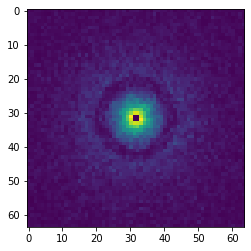

In [7]:
plt.imshow(subset[2, 1, 1, 6, 0,0])

In [5]:
# use less data set
# same to previous data set
# then only difference is the preprocessing

In [6]:
y = np.zeros(subset.shape[:-2], dtype=int)
for i in range(5):
    y[i] = i

In [7]:
x = subset.reshape(-1, subset.shape[-4], subset.shape[-3], subset.shape[-2], subset.shape[-1])
y = y.reshape(-1, subset.shape[-4], subset.shape[-3])

In [8]:
subset.shape

(5, 3, 3, 32, 5, 24, 64, 64)

In [9]:
45 * 32 * 5 * 24 * 0.6

103680.0

In [10]:
810 * 128

103680

In [11]:
# shuffle

np.random.seed(0)
index = np.arange(np.cumprod(subset.shape)[3])
np.random.shuffle(index)

x = x[index]
y = y[index]

In [12]:
x = x.reshape(-1, 64, 64)
y = y.reshape(-1)

In [13]:
xprime = np.zeros_like(x)

In [14]:
for i in range(x.shape[0]):
    xnew = x[i]  + 0.1*np.std(x[i])* np.random.random( (64, 64) )
    xnew = (np.log10(xnew) - np.log10(xnew.max()) + 2.) / 2.
    xprime[i] = xnew 

In [15]:
xprime[xprime < 0] = 0

In [16]:
x = xprime

In [17]:
# 0.6: 0.2: 0.2
x_train = x[:int(x.shape[0]*0.6)]
y_train = y[:int(x.shape[0]*0.6)]

x_val = x[int(x.shape[0]*0.6):int(x.shape[0]*0.8)]
y_val = y[int(x.shape[0]*0.6):int(x.shape[0]*0.8)]

x_test  = x[int(x.shape[0]*0.8):]
y_test  = y[int(x.shape[0]*0.8):]

In [18]:
index = np.arange(y_train.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]


index = np.arange(y_val.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

index = np.arange(y_test.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [19]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, measure
from scipy import ndimage, misc

In [20]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=( 64, 64, 1)),
          tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          #tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
          #tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
          #tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(5)
        ])

In [21]:
%load_ext tensorboard
import tensorflow as tf
import datetime

!rm -rf ./logs/ 


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [23]:
decay_steps = 60
initial_learning_rate = 1e-3
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate, decay_steps)


In [24]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [25]:
step = np.arange(60)
decay_steps = 60

In [26]:
accuracies = np.zeros((2, 60))
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# optimizer Adam optimization is a stochastic gradient descent method that is based on
    #  adaptive estimation of first-order and second-order moments
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=loss_fn,
                  metrics=['accuracy'])


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# fits the model on batches with real-time data augmentation:
model.fit(datagen.flow(x_train[:,:,:, None], y_train, batch_size=128),
          validation_data = (x_val[:,:,:, None], y_val),
                    callbacks=[tensorboard_callback], epochs=60)
#model.fit(x_train[:,:,:, None], y_train, epochs= 1, batch_size = 128,
#                   validation_data = (x_val[:,:,:, None], y_val),
#                    callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
Train for 810 steps, validate on 34560 samples
Epoch 1/60
810/810 [==============================] - 56s 69ms/step - loss: 0.7692 - accuracy: 0.6494 - val_loss: 0.6490 - val_accuracy: 0.7023
Epoch 2/60
810/810 [==============================] - 55s 68ms/step - loss: 0.4431 - accuracy: 0.8049 - val_loss: 0.4195 - val_accuracy: 0.8126
Epoch 3/60
810/810 [==============================] - 55s 68ms/step - loss: 0.3523 - accuracy: 0.8456 - val_loss: 0.4558 - val_accuracy: 0.8078
Epoch 4/60
810/810 [==============================] - 56s 69ms/step - loss: 0.2941 - accuracy: 0.8713 - val_loss: 0.4184 - val_accuracy: 0.8398
Epoch 5/60
810/810 [==============================] - 55s 68ms/step - loss: 0.2565 - accuracy: 0.8883 - val_loss: 0.3860 - val_accuracy: 0.8556
Epoch 6/60
810/810 [==============================] - 56s 69ms/step - loss: 0.2300 - accuracy: 0.9017 - val_loss: 0.3978 - val_accuracy: 0.8479
Epoch 7/60
810/810 [==============================] - 55s 68ms/s

In [20]:
model = tf.keras.models.load_model("model_nov1_datagen/model")

In [27]:
model.fit(datagen.flow(x_train[:,:,:, None], y_train, batch_size=128),
          validation_data = (x_val[:,:,:, None], y_val),
                    callbacks=[tensorboard_callback, lr_scheduler], epochs=180)
#model.fit(x_train[:,:,:, None], y_train, epochs= 1, batch_size = 128,
#                   validation_data = (x_val[:,:,:, None], y_val),
#                    callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
Train for 810 steps, validate on 34560 samples
Epoch 1/180
810/810 [==============================] - 76s 94ms/step - loss: 0.6618 - accuracy: 0.7145 - val_loss: 0.6331 - val_accuracy: 0.7079
Epoch 2/180
810/810 [==============================] - 76s 93ms/step - loss: 0.6000 - accuracy: 0.7402 - val_loss: 0.6495 - val_accuracy: 0.7043
Epoch 3/180
810/810 [==============================] - 76s 93ms/step - loss: 0.5885 - accuracy: 0.7425 - val_loss: 0.6082 - val_accuracy: 0.7273
Epoch 4/180
810/810 [==============================] - 76s 94ms/step - loss: 0.5740 - accuracy: 0.7510 - val_loss: 0.6317 - val_accuracy: 0.7098
Epoch 5/180
810/810 [==============================] - 75s 93ms/step - loss: 0.5802 - accuracy: 0.7471 - val_loss: 0.6216 - val_accuracy: 0.7283
Epoch 6/180
810/810 [==============================] - 75s 93ms/step - loss: 0.5921 - accuracy: 0.7402 - val_loss: 0.5855 - val_accuracy: 0.7323
Epoch 7/180
810/810 [==============================] - 75s

KeyboardInterrupt: 

In [25]:
accuracies = np.zeros((2, 60))
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# optimizer Adam optimization is a stochastic gradient descent method that is based on
    #  adaptive estimation of first-order and second-order moments
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=loss_fn,
                  metrics=['accuracy'])


for i in range(60):
    history = model.fit(x_train[:,:,:, None], y_train, epochs= 1, batch_size = 128,
                   validation_data = (x_val[:,:,:, None], y_val),
                    callbacks=[tensorboard_callback, ])
    accuracy_training = history.history['accuracy'][0]
    loss, accuracy_test = model.evaluate(x_test[:,:,:, None],  y_test, verbose=2)
        
    accuracies[0][i] = accuracy_training
    accuracies[1][i] = accuracy_test

Train on 103680 samples, validate on 34560 samples
103424/103680 [============================>.] - ETA: 0s - loss: 1.2396 - accuracy: 0.4154

KeyboardInterrupt: 

In [27]:
model.save("model_nov1_datagen/model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_nov1_datagen/model/assets


In [ ]:
os.system("")

In [28]:
#model = tf.keras.models.load_model("model_oct24/model")

OSError: SavedModel file does not exist at: model_oct24/model/{saved_model.pbtxt|saved_model.pb}

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        9280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       1

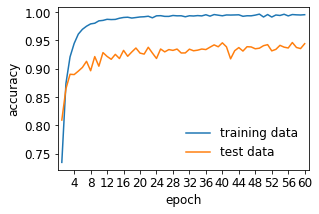

In [33]:
plt.rc("font", size=12)
plt.figure(figsize=(4.5, 3))
plt.plot(np.arange(1, 61), accuracies[0, :], label='training data')
plt.plot(np.arange(1, 61), accuracies[1, :], label='test data')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(4, 61, 4))
plt.xlim(0, 61)
plt.legend(frameon=0)
#plt.savefig("accuracy.pdf", bbox_inches='tight', transparent=True)

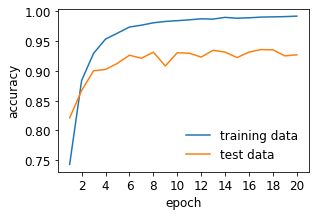

In [77]:
plt.rc("font", size=12)
plt.figure(figsize=(4.5, 3))
plt.plot(np.arange(1, 21), accuracies[0, :], label='training data')
plt.plot(np.arange(1, 21), accuracies[1, :], label='test data')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(2, 21, 2))
plt.xlim(0, 21)
plt.legend(frameon=0)
#plt.savefig("accuracy.pdf", bbox_inches='tight', transparent=True)

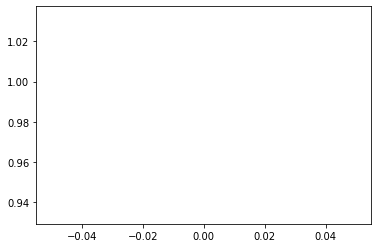

In [26]:
plt.plot(accuracy_training)

In [57]:
datagen.flow(x_train[:,:,:, None], y_train, batch_size=32).data_format

'channels_last'

In [58]:
x_train[:,:,:, None].shape

(103680, 64, 64, 1)

In [59]:
y_train.shape

(103680,)

In [ ]:
accuracies = np.zeros((2, 20))
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# optimizer Adam optimization is a stochastic gradient descent method that is based on
    #  adaptive estimation of first-order and second-order moments
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=loss_fn,
                  metrics=['accuracy'])


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# fits the model on batches with real-time data augmentation:
model.fit(datagen.flow(x_train[:,:,:, None], y_train, batch_size=128),
          validation_data = (x_val[:,:,:, None], y_val),
                    callbacks=[tensorboard_callback], epochs=20)
#model.fit(x_train[:,:,:, None], y_train, epochs= 1, batch_size = 128,
#                   validation_data = (x_val[:,:,:, None], y_val),
#                    callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
Train for 810 steps, validate on 34560 samples
Epoch 1/20
810/810 [==============================] - 63s 78ms/step - loss: 0.8244 - accuracy: 0.6210 - val_loss: 0.7063 - val_accuracy: 0.6887
Epoch 2/20
810/810 [==============================] - 56s 69ms/step - loss: 0.5384 - accuracy: 0.7531 - val_loss: 0.6801 - val_accuracy: 0.7119
Epoch 3/20
810/810 [==============================] - 55s 68ms/step - loss: 0.4468 - accuracy: 0.7944 - val_loss: 0.4816 - val_accuracy: 0.7797
Epoch 4/20
810/810 [==============================] - 56s 69ms/step - loss: 0.3966 - accuracy: 0.8187 - val_loss: 0.4488 - val_accuracy: 0.7910
Epoch 5/20
810/810 [==============================] - 55s 68ms/step - loss: 0.3632 - accuracy: 0.8334 - val_loss: 0.5094 - val_accuracy: 0.7899
Epoch 6/20
810/810 [==============================] - 56s 69ms/step - loss: 0.3351 - accuracy: 0.8465 - val_loss: 0.5116 - val_accuracy: 0.7876
Epoch 7/20
810/810 [==============================] - 55s 67ms/s

In [20]:
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [27]:
test_img = np.load("GW_Lup_incl.npy")
model.predict_classes(test_img[None,:,:,None]/2.)

array([0])

array([0])

In [28]:
loss, accuracy_test = model.evaluate(x_test[:,:,:, None],  y_test, verbose=2)

34560/34560 - 4s - loss: 0.6693 - accuracy: 0.8930


In [29]:
y_predict = model.predict_classes(x_test[:,:,:,None])

([<matplotlib.axis.YTick at 0x7f56dc5da150>,
 <a list of 5 Text yticklabel objects>)

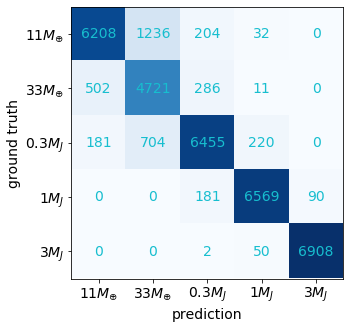

In [30]:
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=14)
plt.figure(figsize=(7.5,5))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(confusion_mat[i][j]), color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])

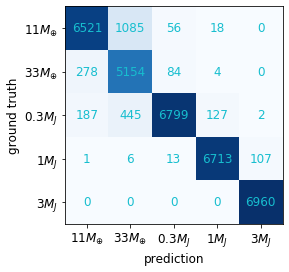

In [62]:
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=12)
plt.figure(figsize=(4.5,4))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(confusion_mat[i][j]), color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.savefig("confusion_mat.pdf", bbox_inches='tight', transparent=True)

In [65]:
str?

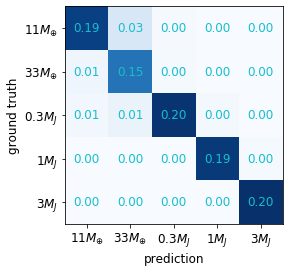

In [67]:
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=12)
plt.figure(figsize=(4.5,4))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, f"{confusion_mat[i][j]/confusion_mat.sum():.2f}", color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
#plt.savefig("confusion_mat_frac.pdf", bbox_inches='tight', transparent=True)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        9280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [ ]:
mod

In [49]:
img_size = (64, 64)

#last_conv_layer_name = "conv2d_3"
last_conv_layer_name = "max_pooling2d_1"
classifier_layer_names = [
 #   "max_pooling2d_1",
 #   "conv2d_4",
 #   "conv2d_5",
 #   "max_pooling2d_2",
    "flatten",
    "dense",
    "dropout",
    "dense_1",
    "dropout_1",
    "dense_2",
    "dropout_2",
    "dense_3"
]

from tensorflow import keras
import matplotlib.cm as cm

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap




In [31]:
img_size = (64, 64)
#last_conv_layer_name = "conv2d_5"
last_conv_layer_name = "conv2d_3"
#last_conv_layer_name = "max_pooling2d_1"
classifier_layer_names = [
    "max_pooling2d_1",
    "conv2d_4",
    "conv2d_5",
    "max_pooling2d_2",
    "flatten",
    "dense",
    "dropout",
    "dense_1",
    "dropout_1",
    "dense_2",
    "dropout_2",
    "dense_3"
]

from tensorflow import keras
import matplotlib.cm as cm

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap





In [32]:
# Generate class activation heatmap
for i in range(0):
    plt.figure()
    img_array = subset[None, 2, 1, 1, 11, 2, i, :, :, None]
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )

    # Display heatmap
    plt.matshow(heatmap, origin='lower')
    plt.colorbar()
    plt.show()

In [44]:
Elias24 = np.load("AS_209.npy")

In [45]:
Elias24 = Elias24 / 2.

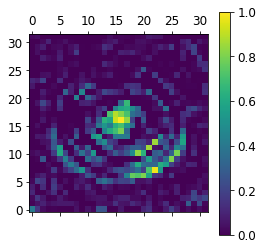

In [46]:
# Generate class activation heatmap
img_array = Elias24[None, :, :, None]
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap, origin='lower')
plt.colorbar()
plt.show()

In [47]:
model.predict_classes(Elias24[None,:,:,None])

array([1])

In [48]:
model.predict_proba(Elias24[None,:,:,None])

array([[  38.31413   ,   62.95193   ,   42.318752  ,   -0.87460583,
        -334.66763   ]], dtype=float32)

/home/shjzhang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'rasterized'
  del sys.path[0]


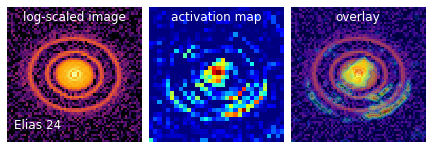

In [49]:
plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
plt.subplot(131)
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.text(0.5, 0.9, "log-scaled image", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, "Elias 24", transform=plt.gca().transAxes, color='w', horizontalalignment='left')
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.5, 0.9, "activation map", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')
plt.subplot(133)
plt.contourf(heatmap, alpha=0.3, cmap='jet', rasterized=True)
plt.text(0.5, 0.9, "overlay", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig("Elias24.pdf", bbox_inches='tight', transparent=True)

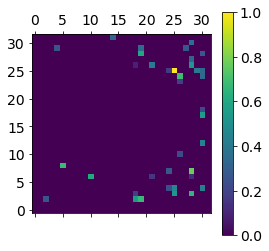

In [38]:
# Generate class activation heatmap
img_array = subset[None, 3, 0, 1, 11, 2, 9, :, :, None]
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap, origin='lower')
plt.colorbar()
plt.show()

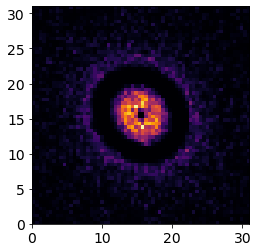

In [39]:
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')

/home/shjzhang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'rasterized'
  del sys.path[0]


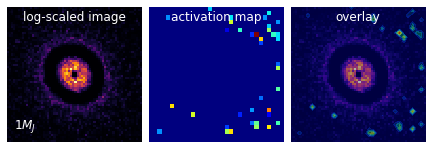

In [40]:
plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
plt.subplot(131)
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.text(0.5, 0.9, "log-scaled image", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, r"1$M_J$", transform=plt.gca().transAxes, color='w', horizontalalignment='left')
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.5, 0.9, "activation map", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')
plt.subplot(133)
plt.contourf(heatmap, alpha=0.3, cmap='jet', rasterized=True)
plt.text(0.5, 0.9, "overlay", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig("gradcam.pdf", bbox_inches='tight', transparent=True)

/home/shjzhang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'rasterized'
  del sys.path[0]


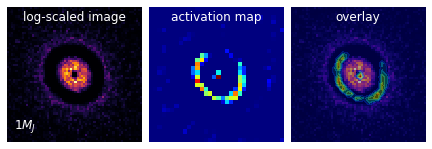

In [124]:
plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
plt.subplot(131)
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.text(0.5, 0.9, "log-scaled image", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, r"1$M_J$", transform=plt.gca().transAxes, color='w', horizontalalignment='left')
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.5, 0.9, "activation map", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')
plt.subplot(133)
plt.contourf(heatmap, alpha=0.3, cmap='jet', rasterized=True)
plt.text(0.5, 0.9, "overlay", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig("gradcam.pdf", bbox_inches='tight', transparent=True)

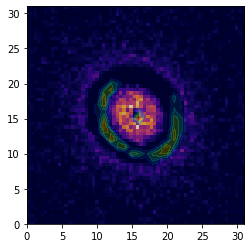

In [93]:
plt.contourf(heatmap, alpha=0.2, cmap='jet')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')


In [ ]:
subset[None, 0, 0, 0, 0, 0, 0, :, :, None]

In [41]:
plt.imshow(Elias24)

NameError: name 'Elias24' is not defined

In [42]:
# Generate class activation heatmap
img_array = Elias24[None, :, :, None]/2.
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap, origin='lower')
plt.colorbar()
plt.show()

NameError: name 'Elias24' is not defined

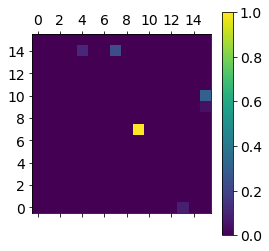

In [30]:
# Generate class activation heatmap
img_array = x[None, 9000,:,:,None]
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap, origin='lower')
plt.colorbar()
plt.show()

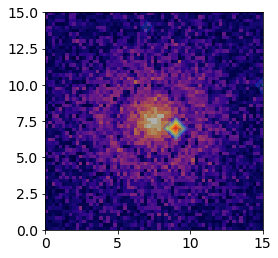

In [31]:
plt.contourf(heatmap, alpha=0.3, cmap='jet')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(x[3000], extent=(0, 15,0, 15), origin='lower', cmap='inferno')

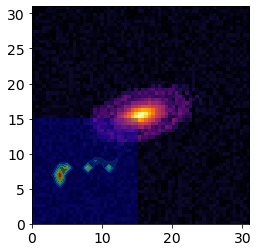

In [58]:
plt.contourf(heatmap, alpha=0.3, cmap='jet')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(x[1800], extent=(0,31,0,31), origin='lower', cmap='inferno')

(0.0, 31.0, 0.0, 31.0)

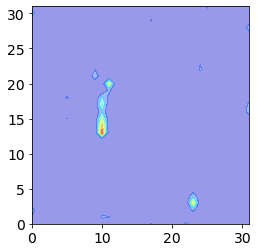

In [47]:
plt.contourf(heatmap, alpha=0.4, cmap='jet')
plt.axis("scaled")

In [ ]:
plt.imshow(x[50], extent=(0,31,0,31), origin='lower', cmap='inferno')

In [26]:
subset.shape

(5, 3, 3, 32, 5, 24, 64, 64)

In [27]:
5* 3* 3* 32* 5* 24 * 0.2

172800